# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
class Transforms:
  """
  Helper class to create test and train transforms
  """
  def __init__(self, normalize=False, mean=None, stdev=None):
    if normalize and (not mean or not stdev):
      raise ValueError('mean and stdev both are required for normalize transform')
  
    self.normalize=normalize
    self.mean = mean
    self.stdev = stdev

  def test_transforms(self):
    transforms_list = [transforms.ToTensor()]
    if(self.normalize):
      transforms_list.append(transforms.Normalize((self.mean,), (self.stdev,)))
    return transforms.Compose(transforms_list)

  def train_transforms(self, pre_transforms=None):
    if pre_transforms:
      transforms_list = pre_transforms
    else:
      transforms_list = []
    transforms_list.append(transforms.ToTensor())

    if(self.normalize):
      transforms_list.append(transforms.Normalize((self.mean,), (self.stdev,)))
    return transforms.Compose(transforms_list)

trans = Transforms(normalize=True, mean=0.1307, stdev=0.3081)

# Train Phase transformations
train_transforms = trans.train_transforms([
                                       #  transforms.Resize((28, 28)),
                                       #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-15.0, 15.0), fill=(1,)),
                                       #  transforms.RandomErasing(),
                                       ])

# Test Phase transformations
test_transforms = trans.test_transforms()


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [0]:
class DataLoader:
  """
  Helper class to load test and train data
  """
  def __init__(self, shuffle=True, batch_size=128, seed=1):
    cuda = torch.cuda.is_available()
    
    if cuda:
      torch.cuda.manual_seed(seed)

    # dataloader arguments - something you'll fetch these from cmdprmt
    self.dataloader_args = dict(shuffle=shuffle, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=shuffle, batch_size=batch_size)

  def load(self, data):
    return torch.utils.data.DataLoader(data, **self.dataloader_args)

dataloader = DataLoader()

# train dataloader
train_loader = dataloader.load(train)

# test dataloader
test_loader = dataloader.load(test)

# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

torch.Size([128, 1, 28, 28])
torch.Size([128])


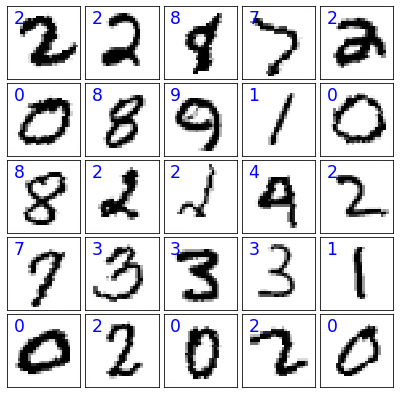

In [5]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
def show25(images, labels):
  r, c = 5, 5
  figmatrix = plt.figure(figsize=(7, 7))
  gs1 = gridspec.GridSpec(r, c)
  gs1.update(wspace=0.005, hspace=0.05) # set the 
  for i in range(1, r*c+1):
    plt.subplot(gs1[i-1])
    plt.tick_params( axis='both', which='both', labelbottom=False, labelleft=False, left=False, bottom=False)
    plt.imshow(images[i-1].numpy().squeeze(), cmap='gray_r')
    plt.text(2, 6, labels[i-1].numpy(), color="blue", fontsize="xx-large")
  plt.show()

show25(images[:25], labels[:25])

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

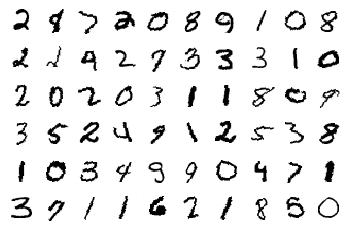

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model

## Target
1. Less than 7000 parameters
2. Less than 15 epochs
3. Test with Cyclic LR
4. Add small dropout of 6%

## Results
1. Number of Parameters = 6202 + 140 non trainable BN params
2. Best Train Accuracy = 98.97
3. Best Test Accuracy = 99.45

## Analysis
1. We pushed the model to achieve target with approx 6000 Parameters
2. Drop in accuracy was predicted because of making the training more difficult. But still we met the target.

In [7]:
!pip install torchsummary
from torchsummary import summary

class Net(nn.Module):
    
    def create_conv2d(self, in_channels, out_channels, kernel_size=(3,3), padding=1, bias=False, bn=True, dropout=0, relu=True):
      l = [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding, bias=bias)]
      if bn:
        l.append(nn.BatchNorm2d(out_channels))
      if dropout>0:
        l.append(nn.Dropout(dropout))
      if relu:
        l.append(nn.ReLU())

      return nn.Sequential(*l)

    def __init__(self, name="Model", dropout_value=0):
        super(Net, self).__init__()
        
        self.name = name

        # Input Convolution Block
        self.convblock1 = self.create_conv2d(1, 10, dropout=dropout_value) # input_size = 28, output_size = 28, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = self.create_conv2d(10, 10, dropout=dropout_value) # output_size = 28, RF = 5

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12, RF = 6

        self.convblock3 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 12, RF = 10

        # CONVOLUTION BLOCK 2
        self.convblock4 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 10, RF = 14

        self.convblock5 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 8, RF = 18

        self.convblock6 = self.create_conv2d(10, 10, dropout=dropout_value, padding=0) # output_size = 6, RF = 22

        self.convblock7 = self.create_conv2d(10, 16, dropout=dropout_value, padding=0) # output_size = 4, RF = 26

        # OUTPUT BLOCK
        self.gap = nn.AvgPool2d(kernel_size=(4,4)) 

        self.convblock8 = self.create_conv2d(16, 10, kernel_size=(1,1), padding=0, bn=False, relu=False) # output_size = 1, RF = 26

        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

    def summary(self, input_size): #input_size=(1, 28, 28)
      summary(self, input_size=input_size)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
model = Net()
model.summary((1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             900
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
         MaxPool2d-7           [-1, 10, 14, 14]               0
            Conv2d-8           [-1, 10, 12, 12]             900
       BatchNorm2d-9           [-1, 10, 12, 12]              20
             ReLU-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 10, 10, 10]             900
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
           Conv2d-14             [-1, 1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from google.colab import drive
drive.mount('/content/drive')
import json
class ModelStats:
  def __init__(self, model):
    self.model = model
    self.batch_train_loss = []
    self.batch_train_acc = []
    self.batch_lr = []
    
    self.avg_test_loss = []
    self.test_acc = []

    self.train_acc = []
    self.avg_train_loss = []
    self.lr = []

    self.batches = 0
    self.epochs = 0

    self.curr_train_acc = 0
    self.curr_train_loss = 0
    self.curr_test_acc = 0
    self.curr_test_loss = 0
    self.train_samples_seen = 0
    self.test_samples_seen = 0
    self.best_test_loss = 100000
    

  def add_batch_train_stats(self, loss, acc, cnt, lr):
    self.batches += 1
    self.batch_train_loss.append(loss)
    self.batch_train_acc.append(acc)
    self.curr_train_loss += loss
    self.curr_train_acc += acc
    self.train_samples_seen += cnt
    self.batch_lr.append(lr)

  def add_batch_test_stats(self, loss, acc, cnt):
    self.curr_test_loss += loss
    self.curr_test_acc += acc
    self.test_samples_seen += cnt

  def next_epoch(self, lr):
    self.epochs += 1
    #print(self.curr_test_loss, self.test_samples_seen, self.curr_train_loss, self.train_samples_seen)
    self.avg_test_loss.append(self.curr_test_loss/self.test_samples_seen)
    self.test_acc.append(self.curr_test_acc/self.test_samples_seen)
    self.avg_train_loss.append(self.curr_train_loss/self.train_samples_seen)
    self.train_acc.append(self.curr_train_acc/self.train_samples_seen)
    self.lr.append(lr)
    self.curr_train_acc = 0
    self.curr_train_loss = 0
    self.curr_test_acc = 0
    self.curr_test_loss = 0
    self.train_samples_seen = 0
    self.test_samples_seen = 0

    if self.epochs == 1 or self.best_test_loss > self.avg_test_loss[-1]:
      print(f'Validation loss decreased ({self.best_test_loss:.6f} --> {self.avg_test_loss[-1]:.6f}).  Saving model ...')
      torch.save(self.model.state_dict(), f"/content/drive/My Drive/{self.model.name}.pt")
      self.best_test_loss = self.avg_test_loss[-1]

  def save(self):
    s = {"batch_train_loss":self.batch_train_loss, "batch_train_acc":self.batch_train_acc,
         "batch_lr":self.batch_lr, "avg_test_loss": self.avg_test_loss, "test_acc": self.test_acc,
         "train_acc": self.train_acc, "avg_train_loss" : self.avg_train_loss, "lr": self.lr,
         "best_test_loss": self.best_test_loss, "epochs": self.epochs}
    with open(f'/content/drive/My Drive/{self.model.name}_stats.json', 'w') as fp:
      json.dump(s, fp, sort_keys=True, indent=4)


  def get_latest_batch_desc(self):
    if len(self.batch_train_loss)==0:
      return "first batch"
    return f'Batch={self.batches} Loss={self.batch_train_loss[-1]:0.4f} Acc={100*self.curr_train_acc/self.train_samples_seen:0.2f}%'

  def get_epoch_desc(self):
    return f'Epoch: {self.epochs}, Train set: Average loss: {self.avg_train_loss[-1]:.4f}, Accuracy: {100*self.train_acc[-1]:.2f}%; Test set: Average loss: {self.avg_test_loss[-1]:.4f}, Accuracy: {100*self.test_acc[-1]:.2f}%'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from tqdm import tqdm_notebook, tnrange
# https://github.com/tqdm/tqdm
class Train:
  def __init__(self, model, dataloader, optimizer, stats, scheduler=None, L1lambda = 0):
    self.model = model
    self.dataloader = dataloader
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.stats = stats
    self.L1lambda = L1lambda

  def run(self):
    self.model.train()
    pbar = tqdm_notebook(self.dataloader)
    for data, target in pbar:
      # get samples
      data, target = data.to(self.model.device), target.to(self.model.device)

      # Init
      self.optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = self.model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Implementing L1 regularization
      if self.L1lambda > 0:
        reg_loss = 0.
        for param in self.model.parameters():
          reg_loss += torch.sum(param.abs())
        loss += self.L1lambda * reg_loss


      # Backpropagation
      loss.backward()
      self.optimizer.step()

      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct = pred.eq(target.view_as(pred)).sum().item()
      lr = self.scheduler.get_last_lr()[0] if self.scheduler else (self.optimizer.lr_scheduler.get_last_lr()[0] if self.optimizer.lr_scheduler else self.optimizer.param_groups[0]['lr'])
      self.stats.add_batch_train_stats(loss.item(), correct, len(data), 0)
      pbar.set_description(self.stats.get_latest_batch_desc())
      if self.scheduler:
        self.scheduler.step()

In [0]:
class Test:
  def __init__(self, model, dataloader, stats):
    self.model = model
    self.dataloader = dataloader
    self.stats = stats

  def run(self):
    self.model.eval()
    with torch.no_grad():
        for data, target in self.dataloader:
            data, target = data.to(self.model.device), target.to(self.model.device)
            output = self.model(data)
            loss = F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct = pred.eq(target.view_as(pred)).sum().item()
            self.stats.add_batch_test_stats(loss, correct, len(data))

# Let's Train and test our model

In [0]:
class ModelTrainer:
  def __init__(self, model, optimizer, train_loader, test_loader, scheduler=None, batch_scheduler=False, L1lambda = 0):
    self.model = model
    self.scheduler = scheduler
    self.batch_scheduler = batch_scheduler
    self.optimizer = optimizer
    self.stats = ModelStats(model)
    self.train = Train(model, train_loader, optimizer, self.stats, self.scheduler if self.scheduler and self.batch_scheduler else None, L1lambda)
    self.test = Test(model, test_loader, self.stats)

  def run(self, epochs=10):
    pbar = tqdm_notebook(range(1, epochs+1), desc="Epochs")
    for epoch in pbar:
      self.train.run()
      self.test.run()
      self.stats.next_epoch(self.scheduler.get_last_lr()[0] if self.scheduler else 0)
      pbar.write(self.stats.get_epoch_desc())
      if self.scheduler and not self.batch_scheduler:
        self.scheduler.step()
      if self.scheduler:
        pbar.write(f"Learning Rate = {self.scheduler.get_last_lr()[0]:0.6f}")
    # save stats for later lookup
    self.stats.save()

In [0]:
#from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR
class RegularizedModel:
  def __init__(self, train_loader, test_loader, name="Model", epochs=2, L1lambda=0, L2lambda=0):
    self.model = Net(f"{name}_{L1lambda}_{L2lambda}", 0.06)
    self.epochs = epochs
    optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=L2lambda)
    #scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.5, steps_per_epoch=len(train_loader), epochs=epochs)
    self.trainer = ModelTrainer(self.model, optimizer, train_loader, test_loader, scheduler, True, L1lambda)
    
  def train(self):
    self.trainer.run(self.epochs)

  def stats(self):
    return self.trainer.stats

In [14]:
EPOCHS = 40 
model00 = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0)
model00.train()

Validation loss decreased (100000.000000 --> 0.069804).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0032, Accuracy: 87.09%; Test set: Average loss: 0.0698, Accuracy: 97.78%
Learning Rate = 0.028181


Validation loss decreased (0.069804 --> 0.050228).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0007, Accuracy: 97.10%; Test set: Average loss: 0.0502, Accuracy: 98.45%
Learning Rate = 0.052165


Validation loss decreased (0.050228 --> 0.035631).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0006, Accuracy: 97.52%; Test set: Average loss: 0.0356, Accuracy: 98.97%
Learning Rate = 0.090318


Validation loss decreased (0.035631 --> 0.034703).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0006, Accuracy: 97.61%; Test set: Average loss: 0.0347, Accuracy: 99.00%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0005, Accuracy: 97.84%; Test set: Average loss: 0.0357, Accuracy: 98.84%
Learning Rate = 0.197937


Validation loss decreased (0.034703 --> 0.032298).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0005, Accuracy: 97.94%; Test set: Average loss: 0.0323, Accuracy: 99.00%
Learning Rate = 0.260067


Validation loss decreased (0.032298 --> 0.024166).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0005, Accuracy: 98.04%; Test set: Average loss: 0.0242, Accuracy: 99.29%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0005, Accuracy: 98.16%; Test set: Average loss: 0.0272, Accuracy: 99.13%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0005, Accuracy: 98.17%; Test set: Average loss: 0.0261, Accuracy: 99.15%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0004, Accuracy: 98.35%; Test set: Average loss: 0.0302, Accuracy: 99.16%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0004, Accuracy: 98.32%; Test set: Average loss: 0.0285, Accuracy: 99.09%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0004, Accuracy: 98.36%; Test set: Average loss: 0.0313, Accuracy: 99.02%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0004, Accuracy: 98.54%; Test set: Average loss: 0.0249, Accuracy: 99.21%
Learning Rate = 0.498421


Validation loss decreased (0.024166 --> 0.023032).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0004, Accuracy: 98.41%; Test set: Average loss: 0.0230, Accuracy: 99.22%
Learning Rate = 0.493719


Validation loss decreased (0.023032 --> 0.019214).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 98.47%; Test set: Average loss: 0.0192, Accuracy: 99.37%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 98.62%; Test set: Average loss: 0.0194, Accuracy: 99.45%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0003, Accuracy: 98.63%; Test set: Average loss: 0.0226, Accuracy: 99.32%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0003, Accuracy: 98.66%; Test set: Average loss: 0.0225, Accuracy: 99.30%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0003, Accuracy: 98.66%; Test set: Average loss: 0.0204, Accuracy: 99.35%
Learning Rate = 0.426735


Validation loss decreased (0.019214 --> 0.017892).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0003, Accuracy: 98.68%; Test set: Average loss: 0.0179, Accuracy: 99.50%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0003, Accuracy: 98.73%; Test set: Average loss: 0.0225, Accuracy: 99.31%
Learning Rate = 0.382958


Validation loss decreased (0.017892 --> 0.016767).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0003, Accuracy: 98.74%; Test set: Average loss: 0.0168, Accuracy: 99.50%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0003, Accuracy: 98.76%; Test set: Average loss: 0.0215, Accuracy: 99.37%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0003, Accuracy: 98.76%; Test set: Average loss: 0.0211, Accuracy: 99.35%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0003, Accuracy: 98.75%; Test set: Average loss: 0.0190, Accuracy: 99.45%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0003, Accuracy: 98.85%; Test set: Average loss: 0.0179, Accuracy: 99.48%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0003, Accuracy: 98.81%; Test set: Average loss: 0.0176, Accuracy: 99.42%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0003, Accuracy: 98.89%; Test set: Average loss: 0.0178, Accuracy: 99.51%
Learning Rate = 0.194313


Validation loss decreased (0.016767 --> 0.016178).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0003, Accuracy: 98.90%; Test set: Average loss: 0.0162, Accuracy: 99.50%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0003, Accuracy: 98.98%; Test set: Average loss: 0.0168, Accuracy: 99.48%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0003, Accuracy: 98.97%; Test set: Average loss: 0.0163, Accuracy: 99.51%
Learning Rate = 0.116943


Validation loss decreased (0.016178 --> 0.014898).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0002, Accuracy: 98.99%; Test set: Average loss: 0.0149, Accuracy: 99.53%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0002, Accuracy: 99.01%; Test set: Average loss: 0.0163, Accuracy: 99.45%
Learning Rate = 0.073183


Validation loss decreased (0.014898 --> 0.014646).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0002, Accuracy: 99.09%; Test set: Average loss: 0.0146, Accuracy: 99.51%
Learning Rate = 0.054507


Validation loss decreased (0.014646 --> 0.014530).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0002, Accuracy: 99.12%; Test set: Average loss: 0.0145, Accuracy: 99.51%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0002, Accuracy: 99.06%; Test set: Average loss: 0.0157, Accuracy: 99.50%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0002, Accuracy: 99.12%; Test set: Average loss: 0.0154, Accuracy: 99.49%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0002, Accuracy: 99.12%; Test set: Average loss: 0.0149, Accuracy: 99.49%
Learning Rate = 0.006257


Validation loss decreased (0.014530 --> 0.014362).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0002, Accuracy: 99.16%; Test set: Average loss: 0.0144, Accuracy: 99.54%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0002, Accuracy: 99.17%; Test set: Average loss: 0.0145, Accuracy: 99.52%
Learning Rate = 0.000002



In [15]:
model01a = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0.0001)
model01a.train()

Validation loss decreased (100000.000000 --> 0.048823).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0030, Accuracy: 88.23%; Test set: Average loss: 0.0488, Accuracy: 98.44%
Learning Rate = 0.028181


Validation loss decreased (0.048823 --> 0.042472).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0008, Accuracy: 97.07%; Test set: Average loss: 0.0425, Accuracy: 98.72%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0007, Accuracy: 97.46%; Test set: Average loss: 0.0537, Accuracy: 98.25%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0006, Accuracy: 97.63%; Test set: Average loss: 0.0461, Accuracy: 98.62%
Learning Rate = 0.140039


Validation loss decreased (0.042472 --> 0.041457).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0006, Accuracy: 97.61%; Test set: Average loss: 0.0415, Accuracy: 98.65%
Learning Rate = 0.197937


Validation loss decreased (0.041457 --> 0.031857).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0006, Accuracy: 97.67%; Test set: Average loss: 0.0319, Accuracy: 99.04%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0005, Accuracy: 97.76%; Test set: Average loss: 0.0346, Accuracy: 98.94%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0006, Accuracy: 97.83%; Test set: Average loss: 0.0361, Accuracy: 98.80%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0005, Accuracy: 97.87%; Test set: Average loss: 0.0328, Accuracy: 98.93%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0005, Accuracy: 97.92%; Test set: Average loss: 0.0348, Accuracy: 98.75%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0005, Accuracy: 97.91%; Test set: Average loss: 0.0378, Accuracy: 98.83%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0005, Accuracy: 97.86%; Test set: Average loss: 0.0373, Accuracy: 98.88%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0005, Accuracy: 97.94%; Test set: Average loss: 0.0350, Accuracy: 98.82%
Learning Rate = 0.498421


Validation loss decreased (0.031857 --> 0.030342).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0005, Accuracy: 98.03%; Test set: Average loss: 0.0303, Accuracy: 98.99%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0005, Accuracy: 97.94%; Test set: Average loss: 0.0351, Accuracy: 98.79%
Learning Rate = 0.485951


Validation loss decreased (0.030342 --> 0.027742).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0005, Accuracy: 98.01%; Test set: Average loss: 0.0277, Accuracy: 99.14%
Learning Rate = 0.475216


Validation loss decreased (0.027742 --> 0.026160).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0005, Accuracy: 98.03%; Test set: Average loss: 0.0262, Accuracy: 99.14%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0005, Accuracy: 97.98%; Test set: Average loss: 0.0456, Accuracy: 98.71%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0005, Accuracy: 98.13%; Test set: Average loss: 0.0349, Accuracy: 98.95%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0005, Accuracy: 98.09%; Test set: Average loss: 0.0296, Accuracy: 98.95%
Learning Rate = 0.405826


Validation loss decreased (0.026160 --> 0.023853).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0005, Accuracy: 98.11%; Test set: Average loss: 0.0239, Accuracy: 99.26%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0005, Accuracy: 98.18%; Test set: Average loss: 0.0337, Accuracy: 98.87%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0005, Accuracy: 98.19%; Test set: Average loss: 0.0277, Accuracy: 99.17%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0004, Accuracy: 98.26%; Test set: Average loss: 0.0379, Accuracy: 98.78%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0004, Accuracy: 98.26%; Test set: Average loss: 0.0304, Accuracy: 99.05%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0004, Accuracy: 98.32%; Test set: Average loss: 0.0297, Accuracy: 99.06%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0004, Accuracy: 98.28%; Test set: Average loss: 0.0263, Accuracy: 99.19%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0004, Accuracy: 98.41%; Test set: Average loss: 0.0307, Accuracy: 99.04%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0004, Accuracy: 98.30%; Test set: Average loss: 0.0274, Accuracy: 99.12%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0004, Accuracy: 98.45%; Test set: Average loss: 0.0249, Accuracy: 99.16%
Learning Rate = 0.141477


Validation loss decreased (0.023853 --> 0.022239).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0004, Accuracy: 98.50%; Test set: Average loss: 0.0222, Accuracy: 99.28%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0004, Accuracy: 98.58%; Test set: Average loss: 0.0240, Accuracy: 99.25%
Learning Rate = 0.094082


Validation loss decreased (0.022239 --> 0.018416).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0003, Accuracy: 98.60%; Test set: Average loss: 0.0184, Accuracy: 99.45%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0003, Accuracy: 98.70%; Test set: Average loss: 0.0194, Accuracy: 99.42%
Learning Rate = 0.054507


Validation loss decreased (0.018416 --> 0.017505).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0003, Accuracy: 98.78%; Test set: Average loss: 0.0175, Accuracy: 99.47%
Learning Rate = 0.038289


Validation loss decreased (0.017505 --> 0.015641).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0003, Accuracy: 98.89%; Test set: Average loss: 0.0156, Accuracy: 99.51%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0003, Accuracy: 98.92%; Test set: Average loss: 0.0162, Accuracy: 99.45%
Learning Rate = 0.014011


Validation loss decreased (0.015641 --> 0.015309).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0002, Accuracy: 99.00%; Test set: Average loss: 0.0153, Accuracy: 99.50%
Learning Rate = 0.006257


Validation loss decreased (0.015309 --> 0.014587).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0002, Accuracy: 99.07%; Test set: Average loss: 0.0146, Accuracy: 99.52%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0002, Accuracy: 99.11%; Test set: Average loss: 0.0146, Accuracy: 99.52%
Learning Rate = 0.000002



In [16]:
model01b = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0.001)
model01b.train()

Validation loss decreased (100000.000000 --> 0.056827).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0032, Accuracy: 87.26%; Test set: Average loss: 0.0568, Accuracy: 98.45%
Learning Rate = 0.028181


Validation loss decreased (0.056827 --> 0.054092).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0008, Accuracy: 97.00%; Test set: Average loss: 0.0541, Accuracy: 98.60%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0008, Accuracy: 97.10%; Test set: Average loss: 0.0998, Accuracy: 96.99%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0008, Accuracy: 97.00%; Test set: Average loss: 0.0830, Accuracy: 97.56%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0008, Accuracy: 96.97%; Test set: Average loss: 0.1083, Accuracy: 96.72%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0009, Accuracy: 96.72%; Test set: Average loss: 0.0864, Accuracy: 97.32%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0008, Accuracy: 96.71%; Test set: Average loss: 0.0839, Accuracy: 97.50%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0009, Accuracy: 96.62%; Test set: Average loss: 0.0871, Accuracy: 97.37%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0009, Accuracy: 96.48%; Test set: Average loss: 0.0940, Accuracy: 96.97%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0009, Accuracy: 96.46%; Test set: Average loss: 0.0646, Accuracy: 98.14%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0009, Accuracy: 96.47%; Test set: Average loss: 0.1979, Accuracy: 93.87%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0009, Accuracy: 96.41%; Test set: Average loss: 0.1589, Accuracy: 95.09%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0009, Accuracy: 96.48%; Test set: Average loss: 0.0973, Accuracy: 97.09%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0009, Accuracy: 96.45%; Test set: Average loss: 0.0731, Accuracy: 97.61%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0009, Accuracy: 96.51%; Test set: Average loss: 0.0634, Accuracy: 98.18%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0009, Accuracy: 96.52%; Test set: Average loss: 0.0801, Accuracy: 97.68%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0009, Accuracy: 96.52%; Test set: Average loss: 0.0783, Accuracy: 97.60%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0009, Accuracy: 96.48%; Test set: Average loss: 0.0652, Accuracy: 98.00%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0009, Accuracy: 96.61%; Test set: Average loss: 0.0861, Accuracy: 97.34%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0009, Accuracy: 96.55%; Test set: Average loss: 0.0702, Accuracy: 97.98%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0009, Accuracy: 96.62%; Test set: Average loss: 0.0831, Accuracy: 97.53%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0009, Accuracy: 96.69%; Test set: Average loss: 0.0679, Accuracy: 98.04%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0009, Accuracy: 96.70%; Test set: Average loss: 0.0692, Accuracy: 97.91%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0008, Accuracy: 96.90%; Test set: Average loss: 0.0962, Accuracy: 96.99%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0008, Accuracy: 96.74%; Test set: Average loss: 0.0616, Accuracy: 98.12%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0008, Accuracy: 96.96%; Test set: Average loss: 0.0588, Accuracy: 98.12%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0008, Accuracy: 97.05%; Test set: Average loss: 0.1014, Accuracy: 96.85%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0008, Accuracy: 97.02%; Test set: Average loss: 0.0881, Accuracy: 97.23%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0008, Accuracy: 97.16%; Test set: Average loss: 0.2505, Accuracy: 92.27%
Learning Rate = 0.167375


Validation loss decreased (0.054092 --> 0.053388).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0007, Accuracy: 97.15%; Test set: Average loss: 0.0534, Accuracy: 98.30%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0007, Accuracy: 97.30%; Test set: Average loss: 0.0630, Accuracy: 98.10%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0007, Accuracy: 97.35%; Test set: Average loss: 0.0755, Accuracy: 97.82%
Learning Rate = 0.094082


Validation loss decreased (0.053388 --> 0.047107).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0006, Accuracy: 97.60%; Test set: Average loss: 0.0471, Accuracy: 98.68%
Learning Rate = 0.073183


Validation loss decreased (0.047107 --> 0.041186).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0006, Accuracy: 97.66%; Test set: Average loss: 0.0412, Accuracy: 98.69%
Learning Rate = 0.054507


Validation loss decreased (0.041186 --> 0.037407).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0006, Accuracy: 97.92%; Test set: Average loss: 0.0374, Accuracy: 98.78%
Learning Rate = 0.038289


Validation loss decreased (0.037407 --> 0.028686).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0005, Accuracy: 98.04%; Test set: Average loss: 0.0287, Accuracy: 99.12%
Learning Rate = 0.024734


Validation loss decreased (0.028686 --> 0.026341).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0005, Accuracy: 98.35%; Test set: Average loss: 0.0263, Accuracy: 99.21%
Learning Rate = 0.014011


Validation loss decreased (0.026341 --> 0.021920).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0004, Accuracy: 98.56%; Test set: Average loss: 0.0219, Accuracy: 99.32%
Learning Rate = 0.006257


Validation loss decreased (0.021920 --> 0.019883).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0004, Accuracy: 98.68%; Test set: Average loss: 0.0199, Accuracy: 99.48%
Learning Rate = 0.001567


Validation loss decreased (0.019883 --> 0.019417).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0003, Accuracy: 98.77%; Test set: Average loss: 0.0194, Accuracy: 99.46%
Learning Rate = 0.000002



In [17]:
model01c = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0.01)
model01c.train()

Validation loss decreased (100000.000000 --> 0.107351).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0032, Accuracy: 89.07%; Test set: Average loss: 0.1074, Accuracy: 97.49%
Learning Rate = 0.028181


Epoch: 2, Train set: Average loss: 0.0015, Accuracy: 95.86%; Test set: Average loss: 0.3168, Accuracy: 90.76%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0016, Accuracy: 95.22%; Test set: Average loss: 0.5208, Accuracy: 85.39%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0018, Accuracy: 94.50%; Test set: Average loss: 0.2681, Accuracy: 93.50%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0020, Accuracy: 93.85%; Test set: Average loss: 0.4365, Accuracy: 87.61%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0025, Accuracy: 91.49%; Test set: Average loss: 0.5610, Accuracy: 83.18%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0036, Accuracy: 86.85%; Test set: Average loss: 4.0985, Accuracy: 16.79%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0038, Accuracy: 86.17%; Test set: Average loss: 3.6892, Accuracy: 33.39%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0043, Accuracy: 84.18%; Test set: Average loss: 2.1544, Accuracy: 21.80%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0063, Accuracy: 74.66%; Test set: Average loss: 4.1226, Accuracy: 14.04%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0067, Accuracy: 72.72%; Test set: Average loss: 0.9596, Accuracy: 72.00%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0073, Accuracy: 70.33%; Test set: Average loss: 5.9675, Accuracy: 11.35%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0081, Accuracy: 66.61%; Test set: Average loss: 1.6027, Accuracy: 44.35%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0072, Accuracy: 71.45%; Test set: Average loss: 1.2964, Accuracy: 51.54%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0077, Accuracy: 68.23%; Test set: Average loss: 0.8459, Accuracy: 69.17%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0165, Accuracy: 19.56%; Test set: Average loss: 2.3019, Accuracy: 11.35%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0180, Accuracy: 11.09%; Test set: Average loss: 2.3019, Accuracy: 11.35%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0180, Accuracy: 11.13%; Test set: Average loss: 2.3021, Accuracy: 10.28%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0180, Accuracy: 11.02%; Test set: Average loss: 2.3015, Accuracy: 11.35%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0180, Accuracy: 11.14%; Test set: Average loss: 2.3021, Accuracy: 11.35%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0180, Accuracy: 11.11%; Test set: Average loss: 2.3024, Accuracy: 11.35%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0180, Accuracy: 11.08%; Test set: Average loss: 2.3023, Accuracy: 9.58%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0180, Accuracy: 11.07%; Test set: Average loss: 2.3021, Accuracy: 11.35%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0180, Accuracy: 11.20%; Test set: Average loss: 2.3022, Accuracy: 11.35%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0180, Accuracy: 11.15%; Test set: Average loss: 2.3023, Accuracy: 11.35%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0180, Accuracy: 11.09%; Test set: Average loss: 2.3021, Accuracy: 11.35%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0180, Accuracy: 11.21%; Test set: Average loss: 2.3023, Accuracy: 11.35%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0180, Accuracy: 11.20%; Test set: Average loss: 2.3021, Accuracy: 11.35%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3016, Accuracy: 11.35%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0180, Accuracy: 11.16%; Test set: Average loss: 2.3017, Accuracy: 11.35%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0180, Accuracy: 11.15%; Test set: Average loss: 2.3023, Accuracy: 11.35%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0180, Accuracy: 11.13%; Test set: Average loss: 2.3019, Accuracy: 11.35%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3017, Accuracy: 11.35%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3014, Accuracy: 11.35%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3018, Accuracy: 11.35%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3019, Accuracy: 11.35%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3016, Accuracy: 11.35%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3016, Accuracy: 11.35%
Learning Rate = 0.006257


Epoch: 39, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3016, Accuracy: 11.35%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0180, Accuracy: 11.24%; Test set: Average loss: 2.3016, Accuracy: 11.35%
Learning Rate = 0.000002



In [18]:
model01d = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0.1)
model01d.train()

Validation loss decreased (100000.000000 --> 2.031049).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0139, Accuracy: 37.65%; Test set: Average loss: 2.0310, Accuracy: 35.82%
Learning Rate = 0.028181


Validation loss decreased (2.031049 --> 1.865047).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0124, Accuracy: 47.60%; Test set: Average loss: 1.8650, Accuracy: 30.11%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0146, Accuracy: 39.36%; Test set: Average loss: 2.7787, Accuracy: 11.35%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0178, Accuracy: 11.46%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.006257


Epoch: 39, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0180, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.000002



In [19]:
model10a = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.0001, 0)
model10a.train()

Validation loss decreased (100000.000000 --> 0.056116).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0033, Accuracy: 89.11%; Test set: Average loss: 0.0561, Accuracy: 98.38%
Learning Rate = 0.028181


Validation loss decreased (0.056116 --> 0.042346).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0013, Accuracy: 97.15%; Test set: Average loss: 0.0423, Accuracy: 98.58%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0013, Accuracy: 97.21%; Test set: Average loss: 0.0538, Accuracy: 98.39%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0014, Accuracy: 97.30%; Test set: Average loss: 0.0748, Accuracy: 97.79%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0014, Accuracy: 97.32%; Test set: Average loss: 0.1019, Accuracy: 97.13%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0015, Accuracy: 97.25%; Test set: Average loss: 0.0665, Accuracy: 97.84%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0015, Accuracy: 97.19%; Test set: Average loss: 0.0476, Accuracy: 98.57%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0015, Accuracy: 97.32%; Test set: Average loss: 0.0630, Accuracy: 98.09%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0015, Accuracy: 97.30%; Test set: Average loss: 0.0683, Accuracy: 97.82%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0015, Accuracy: 97.37%; Test set: Average loss: 0.0547, Accuracy: 98.26%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0015, Accuracy: 97.44%; Test set: Average loss: 0.0466, Accuracy: 98.49%
Learning Rate = 0.491854


Validation loss decreased (0.042346 --> 0.041402).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0015, Accuracy: 97.44%; Test set: Average loss: 0.0414, Accuracy: 98.76%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0015, Accuracy: 97.36%; Test set: Average loss: 0.0494, Accuracy: 98.47%
Learning Rate = 0.498421


Validation loss decreased (0.041402 --> 0.040711).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0015, Accuracy: 97.47%; Test set: Average loss: 0.0407, Accuracy: 98.63%
Learning Rate = 0.493719


Validation loss decreased (0.040711 --> 0.040289).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0015, Accuracy: 97.53%; Test set: Average loss: 0.0403, Accuracy: 98.72%
Learning Rate = 0.485951


Validation loss decreased (0.040289 --> 0.034903).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0015, Accuracy: 97.48%; Test set: Average loss: 0.0349, Accuracy: 98.89%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0015, Accuracy: 97.59%; Test set: Average loss: 0.0368, Accuracy: 98.91%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0015, Accuracy: 97.55%; Test set: Average loss: 0.0600, Accuracy: 98.24%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0015, Accuracy: 97.56%; Test set: Average loss: 0.0359, Accuracy: 98.86%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0015, Accuracy: 97.54%; Test set: Average loss: 0.0459, Accuracy: 98.60%
Learning Rate = 0.405826


Validation loss decreased (0.034903 --> 0.034901).  Saving model ...
Epoch: 21, Train set: Average loss: 0.0014, Accuracy: 97.59%; Test set: Average loss: 0.0349, Accuracy: 98.93%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0014, Accuracy: 97.62%; Test set: Average loss: 0.0481, Accuracy: 98.54%
Learning Rate = 0.358418


Validation loss decreased (0.034901 --> 0.034872).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0014, Accuracy: 97.59%; Test set: Average loss: 0.0349, Accuracy: 98.89%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0014, Accuracy: 97.69%; Test set: Average loss: 0.0410, Accuracy: 98.78%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0014, Accuracy: 97.67%; Test set: Average loss: 0.0448, Accuracy: 98.54%
Learning Rate = 0.277933


Validation loss decreased (0.034872 --> 0.034182).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0014, Accuracy: 97.65%; Test set: Average loss: 0.0342, Accuracy: 98.91%
Learning Rate = 0.249941


Validation loss decreased (0.034182 --> 0.033849).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0013, Accuracy: 97.74%; Test set: Average loss: 0.0338, Accuracy: 98.94%
Learning Rate = 0.221951


Validation loss decreased (0.033849 --> 0.028127).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0013, Accuracy: 97.95%; Test set: Average loss: 0.0281, Accuracy: 99.13%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0013, Accuracy: 97.91%; Test set: Average loss: 0.0361, Accuracy: 98.88%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0013, Accuracy: 97.86%; Test set: Average loss: 0.0313, Accuracy: 98.98%
Learning Rate = 0.141477


Validation loss decreased (0.028127 --> 0.026845).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0012, Accuracy: 97.90%; Test set: Average loss: 0.0268, Accuracy: 99.21%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0012, Accuracy: 98.08%; Test set: Average loss: 0.0288, Accuracy: 99.02%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0011, Accuracy: 98.24%; Test set: Average loss: 0.0306, Accuracy: 99.14%
Learning Rate = 0.073183


Validation loss decreased (0.026845 --> 0.023822).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0011, Accuracy: 98.24%; Test set: Average loss: 0.0238, Accuracy: 99.23%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0010, Accuracy: 98.37%; Test set: Average loss: 0.0240, Accuracy: 99.23%
Learning Rate = 0.038289


Validation loss decreased (0.023822 --> 0.021537).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0010, Accuracy: 98.52%; Test set: Average loss: 0.0215, Accuracy: 99.27%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0009, Accuracy: 98.61%; Test set: Average loss: 0.0219, Accuracy: 99.28%
Learning Rate = 0.014011


Validation loss decreased (0.021537 --> 0.018969).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0009, Accuracy: 98.72%; Test set: Average loss: 0.0190, Accuracy: 99.37%
Learning Rate = 0.006257


Validation loss decreased (0.018969 --> 0.018223).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0008, Accuracy: 98.81%; Test set: Average loss: 0.0182, Accuracy: 99.44%
Learning Rate = 0.001567


Validation loss decreased (0.018223 --> 0.017074).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0008, Accuracy: 98.83%; Test set: Average loss: 0.0171, Accuracy: 99.46%
Learning Rate = 0.000002



In [20]:
model10b = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.001, 0)
model10b.train()

Validation loss decreased (100000.000000 --> 0.078079).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0058, Accuracy: 88.79%; Test set: Average loss: 0.0781, Accuracy: 97.58%
Learning Rate = 0.028181


Epoch: 2, Train set: Average loss: 0.0040, Accuracy: 95.56%; Test set: Average loss: 0.1107, Accuracy: 96.78%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0041, Accuracy: 95.16%; Test set: Average loss: 0.2541, Accuracy: 91.78%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0043, Accuracy: 94.79%; Test set: Average loss: 0.3093, Accuracy: 90.84%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0046, Accuracy: 94.42%; Test set: Average loss: 0.2339, Accuracy: 93.03%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0047, Accuracy: 94.34%; Test set: Average loss: 0.5438, Accuracy: 84.20%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0048, Accuracy: 94.09%; Test set: Average loss: 0.1754, Accuracy: 94.47%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0048, Accuracy: 93.90%; Test set: Average loss: 0.1497, Accuracy: 95.63%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0049, Accuracy: 93.76%; Test set: Average loss: 0.2828, Accuracy: 91.24%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0049, Accuracy: 93.65%; Test set: Average loss: 0.3323, Accuracy: 89.50%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0049, Accuracy: 93.63%; Test set: Average loss: 0.3078, Accuracy: 90.69%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0050, Accuracy: 93.68%; Test set: Average loss: 0.3571, Accuracy: 88.99%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0050, Accuracy: 93.62%; Test set: Average loss: 0.1538, Accuracy: 95.50%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0049, Accuracy: 93.81%; Test set: Average loss: 0.1729, Accuracy: 94.32%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0049, Accuracy: 93.72%; Test set: Average loss: 0.5273, Accuracy: 82.68%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0049, Accuracy: 93.62%; Test set: Average loss: 0.3841, Accuracy: 87.93%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0049, Accuracy: 93.66%; Test set: Average loss: 0.8195, Accuracy: 75.33%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0048, Accuracy: 93.81%; Test set: Average loss: 0.2362, Accuracy: 92.85%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0048, Accuracy: 93.87%; Test set: Average loss: 0.6880, Accuracy: 79.00%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0047, Accuracy: 93.83%; Test set: Average loss: 0.2449, Accuracy: 91.84%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0047, Accuracy: 93.90%; Test set: Average loss: 0.5179, Accuracy: 82.74%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0046, Accuracy: 93.91%; Test set: Average loss: 0.2035, Accuracy: 93.66%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0046, Accuracy: 93.91%; Test set: Average loss: 0.1583, Accuracy: 94.92%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0045, Accuracy: 94.15%; Test set: Average loss: 0.1853, Accuracy: 94.48%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0044, Accuracy: 94.20%; Test set: Average loss: 1.0542, Accuracy: 74.97%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0044, Accuracy: 94.23%; Test set: Average loss: 0.1424, Accuracy: 95.75%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0043, Accuracy: 94.22%; Test set: Average loss: 0.1349, Accuracy: 96.12%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0042, Accuracy: 94.51%; Test set: Average loss: 0.3008, Accuracy: 90.01%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0041, Accuracy: 94.54%; Test set: Average loss: 0.1745, Accuracy: 94.76%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0040, Accuracy: 94.59%; Test set: Average loss: 0.1752, Accuracy: 94.58%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0038, Accuracy: 94.89%; Test set: Average loss: 0.2545, Accuracy: 91.33%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0038, Accuracy: 94.92%; Test set: Average loss: 0.1048, Accuracy: 96.91%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0036, Accuracy: 95.01%; Test set: Average loss: 0.1018, Accuracy: 96.88%
Learning Rate = 0.073183


Validation loss decreased (0.078079 --> 0.071258).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0034, Accuracy: 95.38%; Test set: Average loss: 0.0713, Accuracy: 97.88%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0032, Accuracy: 95.58%; Test set: Average loss: 0.1454, Accuracy: 95.83%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0029, Accuracy: 95.91%; Test set: Average loss: 0.1999, Accuracy: 94.12%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0027, Accuracy: 96.25%; Test set: Average loss: 0.1064, Accuracy: 96.90%
Learning Rate = 0.014011


Validation loss decreased (0.071258 --> 0.054976).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0024, Accuracy: 96.61%; Test set: Average loss: 0.0550, Accuracy: 98.35%
Learning Rate = 0.006257


Validation loss decreased (0.054976 --> 0.045042).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0021, Accuracy: 97.18%; Test set: Average loss: 0.0450, Accuracy: 98.57%
Learning Rate = 0.001567


Validation loss decreased (0.045042 --> 0.038004).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0019, Accuracy: 97.67%; Test set: Average loss: 0.0380, Accuracy: 98.68%
Learning Rate = 0.000002



In [21]:
model10c = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.01, 0)
model10c.train()

Validation loss decreased (100000.000000 --> 0.898419).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0184, Accuracy: 79.83%; Test set: Average loss: 0.8984, Accuracy: 69.89%
Learning Rate = 0.028181


Epoch: 2, Train set: Average loss: 0.0149, Accuracy: 84.97%; Test set: Average loss: 2.0662, Accuracy: 28.07%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0140, Accuracy: 79.72%; Test set: Average loss: 2.0885, Accuracy: 47.21%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0176, Accuracy: 76.19%; Test set: Average loss: 1.3478, Accuracy: 61.84%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0255, Accuracy: 70.04%; Test set: Average loss: 5.6260, Accuracy: 12.34%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0257, Accuracy: 57.19%; Test set: Average loss: 1.3034, Accuracy: 55.68%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0256, Accuracy: 54.52%; Test set: Average loss: 16.7380, Accuracy: 11.35%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0227, Accuracy: 55.42%; Test set: Average loss: 1.7302, Accuracy: 31.38%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0214, Accuracy: 53.69%; Test set: Average loss: 3.0855, Accuracy: 18.96%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0272, Accuracy: 52.32%; Test set: Average loss: 3.4555, Accuracy: 10.10%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0220, Accuracy: 50.34%; Test set: Average loss: 2.8048, Accuracy: 21.43%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0792, Accuracy: 42.91%; Test set: Average loss: 2.0671, Accuracy: 15.30%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0529, Accuracy: 39.55%; Test set: Average loss: 1.4364, Accuracy: 52.39%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0461, Accuracy: 42.16%; Test set: Average loss: 1.5563, Accuracy: 45.12%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.2408, Accuracy: 35.07%; Test set: Average loss: 2.8922, Accuracy: 9.80%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.2411, Accuracy: 24.72%; Test set: Average loss: 2.1897, Accuracy: 17.39%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.1659, Accuracy: 17.52%; Test set: Average loss: 2.3026, Accuracy: 10.10%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.1333, Accuracy: 11.82%; Test set: Average loss: 2.3026, Accuracy: 9.82%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0918, Accuracy: 10.11%; Test set: Average loss: 2.3026, Accuracy: 11.35%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0752, Accuracy: 9.96%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0668, Accuracy: 9.89%; Test set: Average loss: 2.3026, Accuracy: 10.09%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0611, Accuracy: 10.16%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0556, Accuracy: 10.13%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0503, Accuracy: 10.02%; Test set: Average loss: 2.3026, Accuracy: 8.92%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0451, Accuracy: 10.04%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0405, Accuracy: 10.13%; Test set: Average loss: 2.3026, Accuracy: 9.74%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0367, Accuracy: 10.24%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0338, Accuracy: 10.09%; Test set: Average loss: 2.3026, Accuracy: 11.35%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0319, Accuracy: 10.08%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0303, Accuracy: 9.93%; Test set: Average loss: 2.3026, Accuracy: 9.82%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0289, Accuracy: 9.74%; Test set: Average loss: 2.3026, Accuracy: 8.92%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0276, Accuracy: 9.98%; Test set: Average loss: 2.3026, Accuracy: 10.32%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0265, Accuracy: 9.89%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0256, Accuracy: 9.93%; Test set: Average loss: 2.3026, Accuracy: 9.82%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0248, Accuracy: 10.08%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0243, Accuracy: 9.98%; Test set: Average loss: 2.3026, Accuracy: 11.35%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0239, Accuracy: 10.09%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0237, Accuracy: 10.35%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.006257


Epoch: 39, Train set: Average loss: 0.0235, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0235, Accuracy: 10.44%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.000002



In [22]:
model10d = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.1, 0)
model10d.train()

Validation loss decreased (100000.000000 --> 2.302585).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0368, Accuracy: 10.13%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.028181


Validation loss decreased (2.302585 --> 2.302582).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0357, Accuracy: 10.01%; Test set: Average loss: 2.3026, Accuracy: 10.09%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0497, Accuracy: 10.21%; Test set: Average loss: 2.3026, Accuracy: 10.10%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0694, Accuracy: 9.95%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0932, Accuracy: 10.12%; Test set: Average loss: 2.3026, Accuracy: 9.58%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.1193, Accuracy: 9.87%; Test set: Average loss: 2.3042, Accuracy: 11.35%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.1462, Accuracy: 10.03%; Test set: Average loss: 2.3027, Accuracy: 9.74%
Learning Rate = 0.322192


Validation loss decreased (2.302582 --> 2.302518).  Saving model ...
Epoch: 8, Train set: Average loss: 0.1719, Accuracy: 9.90%; Test set: Average loss: 2.3025, Accuracy: 9.58%
Learning Rate = 0.380077


Validation loss decreased (2.302518 --> 2.302359).  Saving model ...
Epoch: 9, Train set: Average loss: 0.1948, Accuracy: 10.10%; Test set: Average loss: 2.3024, Accuracy: 10.71%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.2133, Accuracy: 10.01%; Test set: Average loss: 2.3026, Accuracy: 9.82%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.2262, Accuracy: 9.80%; Test set: Average loss: 2.3025, Accuracy: 9.80%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.2329, Accuracy: 9.83%; Test set: Average loss: 2.3028, Accuracy: 10.28%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.2340, Accuracy: 10.09%; Test set: Average loss: 2.3025, Accuracy: 10.10%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.2328, Accuracy: 10.18%; Test set: Average loss: 2.3030, Accuracy: 9.68%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.2300, Accuracy: 10.09%; Test set: Average loss: 2.3032, Accuracy: 10.38%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.2261, Accuracy: 9.98%; Test set: Average loss: 2.3025, Accuracy: 9.80%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.2211, Accuracy: 10.25%; Test set: Average loss: 2.3027, Accuracy: 9.74%
Learning Rate = 0.461649


Validation loss decreased (2.302359 --> 2.302154).  Saving model ...
Epoch: 18, Train set: Average loss: 0.2149, Accuracy: 10.17%; Test set: Average loss: 2.3022, Accuracy: 9.57%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.2077, Accuracy: 9.99%; Test set: Average loss: 2.3024, Accuracy: 10.27%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.1994, Accuracy: 9.68%; Test set: Average loss: 2.3031, Accuracy: 6.04%
Learning Rate = 0.405826


Validation loss decreased (2.302154 --> 2.302149).  Saving model ...
Epoch: 21, Train set: Average loss: 0.1903, Accuracy: 9.89%; Test set: Average loss: 2.3021, Accuracy: 10.02%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.1803, Accuracy: 10.10%; Test set: Average loss: 2.3028, Accuracy: 9.80%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.1696, Accuracy: 10.28%; Test set: Average loss: 2.3027, Accuracy: 10.11%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.1583, Accuracy: 10.02%; Test set: Average loss: 2.3025, Accuracy: 10.28%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.1465, Accuracy: 10.00%; Test set: Average loss: 2.3024, Accuracy: 7.27%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.1345, Accuracy: 10.10%; Test set: Average loss: 2.3029, Accuracy: 10.09%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.1225, Accuracy: 10.22%; Test set: Average loss: 2.3025, Accuracy: 10.32%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.1105, Accuracy: 10.13%; Test set: Average loss: 2.3026, Accuracy: 10.16%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0987, Accuracy: 10.07%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0872, Accuracy: 10.20%; Test set: Average loss: 2.3026, Accuracy: 11.35%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0762, Accuracy: 9.98%; Test set: Average loss: 2.3026, Accuracy: 9.74%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0657, Accuracy: 9.99%; Test set: Average loss: 2.3026, Accuracy: 11.35%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0559, Accuracy: 10.07%; Test set: Average loss: 2.3026, Accuracy: 10.10%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0471, Accuracy: 10.17%; Test set: Average loss: 2.3026, Accuracy: 9.58%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0392, Accuracy: 10.04%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0324, Accuracy: 10.17%; Test set: Average loss: 2.3026, Accuracy: 10.09%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0268, Accuracy: 10.11%; Test set: Average loss: 2.3026, Accuracy: 9.82%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0226, Accuracy: 10.08%; Test set: Average loss: 2.3026, Accuracy: 9.80%
Learning Rate = 0.006257


Epoch: 39, Train set: Average loss: 0.0197, Accuracy: 10.03%; Test set: Average loss: 2.3026, Accuracy: 8.92%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0182, Accuracy: 10.40%; Test set: Average loss: 2.3026, Accuracy: 10.28%
Learning Rate = 0.000002



# Weights analysis

Here we shall try to see our weights in order to see what valus if L1 and L2 can be used

In [0]:
# let us now evaluate the model weights
#pmin = 
# from functools import reduce
# c = 0
# t = 0
# t2 = 0
# for idx, param in enumerate(model00.model.parameters()):
#   cn = reduce(lambda x,y: x*y, param.size())
#   t += param.abs().sum().item()
#   t2 += (param*param).sum().item() 
#   c += cn
#   print(f"{idx}: MIN = {param.min().item():0.4f}, MAX = {param.max().item():0.4f}, MEAN = {param.mean().item():0.4f}, count = {reduce(lambda x,y: x*y, param.size())}")
# print(t, c, t2, t/c, t2/c)

In [24]:
model01e = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0.00005)
model01e.train()

Validation loss decreased (100000.000000 --> 0.061837).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0027, Accuracy: 89.57%; Test set: Average loss: 0.0618, Accuracy: 98.08%
Learning Rate = 0.028181


Validation loss decreased (0.061837 --> 0.046035).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0008, Accuracy: 96.99%; Test set: Average loss: 0.0460, Accuracy: 98.54%
Learning Rate = 0.052165


Validation loss decreased (0.046035 --> 0.041382).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0007, Accuracy: 97.41%; Test set: Average loss: 0.0414, Accuracy: 98.78%
Learning Rate = 0.090318


Validation loss decreased (0.041382 --> 0.035978).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0006, Accuracy: 97.41%; Test set: Average loss: 0.0360, Accuracy: 98.81%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0006, Accuracy: 97.65%; Test set: Average loss: 0.0679, Accuracy: 97.96%
Learning Rate = 0.197937


Validation loss decreased (0.035978 --> 0.031483).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0005, Accuracy: 97.78%; Test set: Average loss: 0.0315, Accuracy: 98.99%
Learning Rate = 0.260067


Validation loss decreased (0.031483 --> 0.026971).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0005, Accuracy: 97.82%; Test set: Average loss: 0.0270, Accuracy: 99.09%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0005, Accuracy: 97.97%; Test set: Average loss: 0.0270, Accuracy: 99.06%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0005, Accuracy: 98.01%; Test set: Average loss: 0.0380, Accuracy: 98.79%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0005, Accuracy: 98.15%; Test set: Average loss: 0.0391, Accuracy: 98.86%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0005, Accuracy: 98.10%; Test set: Average loss: 0.0348, Accuracy: 99.04%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0005, Accuracy: 98.16%; Test set: Average loss: 0.0282, Accuracy: 99.03%
Learning Rate = 0.500000


Validation loss decreased (0.026971 --> 0.023374).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0005, Accuracy: 98.19%; Test set: Average loss: 0.0234, Accuracy: 99.26%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0004, Accuracy: 98.20%; Test set: Average loss: 0.0239, Accuracy: 99.24%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 98.28%; Test set: Average loss: 0.0245, Accuracy: 99.20%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 98.28%; Test set: Average loss: 0.0331, Accuracy: 98.86%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0004, Accuracy: 98.32%; Test set: Average loss: 0.0271, Accuracy: 99.14%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0004, Accuracy: 98.36%; Test set: Average loss: 0.0278, Accuracy: 99.11%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0004, Accuracy: 98.37%; Test set: Average loss: 0.0311, Accuracy: 98.96%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0004, Accuracy: 98.39%; Test set: Average loss: 0.0292, Accuracy: 99.07%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0004, Accuracy: 98.41%; Test set: Average loss: 0.0350, Accuracy: 98.85%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0004, Accuracy: 98.45%; Test set: Average loss: 0.0343, Accuracy: 98.91%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0004, Accuracy: 98.39%; Test set: Average loss: 0.0332, Accuracy: 98.87%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0004, Accuracy: 98.43%; Test set: Average loss: 0.0250, Accuracy: 99.11%
Learning Rate = 0.305573


Validation loss decreased (0.023374 --> 0.023021).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0004, Accuracy: 98.51%; Test set: Average loss: 0.0230, Accuracy: 99.28%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0004, Accuracy: 98.48%; Test set: Average loss: 0.0244, Accuracy: 99.22%
Learning Rate = 0.249941


Validation loss decreased (0.023021 --> 0.019956).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0004, Accuracy: 98.53%; Test set: Average loss: 0.0200, Accuracy: 99.40%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0003, Accuracy: 98.65%; Test set: Average loss: 0.0204, Accuracy: 99.30%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0004, Accuracy: 98.57%; Test set: Average loss: 0.0232, Accuracy: 99.26%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0003, Accuracy: 98.69%; Test set: Average loss: 0.0206, Accuracy: 99.37%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0003, Accuracy: 98.70%; Test set: Average loss: 0.0210, Accuracy: 99.27%
Learning Rate = 0.116943


Validation loss decreased (0.019956 --> 0.018914).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0003, Accuracy: 98.82%; Test set: Average loss: 0.0189, Accuracy: 99.39%
Learning Rate = 0.094082


Validation loss decreased (0.018914 --> 0.016528).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0003, Accuracy: 98.76%; Test set: Average loss: 0.0165, Accuracy: 99.47%
Learning Rate = 0.073183


Validation loss decreased (0.016528 --> 0.015642).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0003, Accuracy: 98.87%; Test set: Average loss: 0.0156, Accuracy: 99.42%
Learning Rate = 0.054507


Validation loss decreased (0.015642 --> 0.015488).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0003, Accuracy: 98.93%; Test set: Average loss: 0.0155, Accuracy: 99.50%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0003, Accuracy: 99.00%; Test set: Average loss: 0.0171, Accuracy: 99.38%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0002, Accuracy: 99.03%; Test set: Average loss: 0.0161, Accuracy: 99.49%
Learning Rate = 0.014011


Validation loss decreased (0.015488 --> 0.015216).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0002, Accuracy: 99.09%; Test set: Average loss: 0.0152, Accuracy: 99.48%
Learning Rate = 0.006257


Validation loss decreased (0.015216 --> 0.014205).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0002, Accuracy: 99.06%; Test set: Average loss: 0.0142, Accuracy: 99.52%
Learning Rate = 0.001567


Validation loss decreased (0.014205 --> 0.013981).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0002, Accuracy: 99.15%; Test set: Average loss: 0.0140, Accuracy: 99.53%
Learning Rate = 0.000002



In [34]:
model10e = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.00005, 0)
model10e.train()

Validation loss decreased (100000.000000 --> 0.076666).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0034, Accuracy: 87.91%; Test set: Average loss: 0.0767, Accuracy: 97.64%
Learning Rate = 0.028181


Validation loss decreased (0.076666 --> 0.068237).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0011, Accuracy: 97.00%; Test set: Average loss: 0.0682, Accuracy: 97.60%
Learning Rate = 0.052165


Validation loss decreased (0.068237 --> 0.040702).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0010, Accuracy: 97.21%; Test set: Average loss: 0.0407, Accuracy: 98.62%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0010, Accuracy: 97.37%; Test set: Average loss: 0.0555, Accuracy: 98.31%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0011, Accuracy: 97.43%; Test set: Average loss: 0.0455, Accuracy: 98.57%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0011, Accuracy: 97.58%; Test set: Average loss: 0.0604, Accuracy: 98.15%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0011, Accuracy: 97.55%; Test set: Average loss: 0.0476, Accuracy: 98.63%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0011, Accuracy: 97.70%; Test set: Average loss: 0.0591, Accuracy: 98.20%
Learning Rate = 0.380077


Validation loss decreased (0.040702 --> 0.035585).  Saving model ...
Epoch: 9, Train set: Average loss: 0.0011, Accuracy: 97.65%; Test set: Average loss: 0.0356, Accuracy: 98.89%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0011, Accuracy: 97.82%; Test set: Average loss: 0.0385, Accuracy: 98.85%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0011, Accuracy: 97.87%; Test set: Average loss: 0.0391, Accuracy: 98.76%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0011, Accuracy: 97.81%; Test set: Average loss: 0.0409, Accuracy: 98.74%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0011, Accuracy: 97.95%; Test set: Average loss: 0.0454, Accuracy: 98.66%
Learning Rate = 0.498421


Validation loss decreased (0.035585 --> 0.032804).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0011, Accuracy: 97.97%; Test set: Average loss: 0.0328, Accuracy: 98.96%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0011, Accuracy: 98.01%; Test set: Average loss: 0.0409, Accuracy: 98.70%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0011, Accuracy: 97.99%; Test set: Average loss: 0.0401, Accuracy: 98.76%
Learning Rate = 0.475216


Validation loss decreased (0.032804 --> 0.029503).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0011, Accuracy: 98.06%; Test set: Average loss: 0.0295, Accuracy: 99.03%
Learning Rate = 0.461649


Validation loss decreased (0.029503 --> 0.028662).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0011, Accuracy: 98.05%; Test set: Average loss: 0.0287, Accuracy: 99.12%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0010, Accuracy: 98.06%; Test set: Average loss: 0.0416, Accuracy: 98.71%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0010, Accuracy: 98.18%; Test set: Average loss: 0.0342, Accuracy: 98.91%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0010, Accuracy: 98.08%; Test set: Average loss: 0.0305, Accuracy: 99.06%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0010, Accuracy: 98.17%; Test set: Average loss: 0.0325, Accuracy: 98.90%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0010, Accuracy: 98.22%; Test set: Average loss: 0.0334, Accuracy: 99.02%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0010, Accuracy: 98.21%; Test set: Average loss: 0.0330, Accuracy: 98.98%
Learning Rate = 0.305573


Validation loss decreased (0.028662 --> 0.026882).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0010, Accuracy: 98.11%; Test set: Average loss: 0.0269, Accuracy: 99.22%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0010, Accuracy: 98.22%; Test set: Average loss: 0.0287, Accuracy: 99.15%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0010, Accuracy: 98.27%; Test set: Average loss: 0.0361, Accuracy: 98.82%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0009, Accuracy: 98.31%; Test set: Average loss: 0.0300, Accuracy: 99.01%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0009, Accuracy: 98.42%; Test set: Average loss: 0.0277, Accuracy: 99.09%
Learning Rate = 0.167375


Validation loss decreased (0.026882 --> 0.026593).  Saving model ...
Epoch: 30, Train set: Average loss: 0.0009, Accuracy: 98.41%; Test set: Average loss: 0.0266, Accuracy: 99.19%
Learning Rate = 0.141477


Validation loss decreased (0.026593 --> 0.025942).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0009, Accuracy: 98.45%; Test set: Average loss: 0.0259, Accuracy: 99.24%
Learning Rate = 0.116943


Validation loss decreased (0.025942 --> 0.025539).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0009, Accuracy: 98.52%; Test set: Average loss: 0.0255, Accuracy: 99.25%
Learning Rate = 0.094082


Validation loss decreased (0.025539 --> 0.024135).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0008, Accuracy: 98.62%; Test set: Average loss: 0.0241, Accuracy: 99.28%
Learning Rate = 0.073183


Validation loss decreased (0.024135 --> 0.022080).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0008, Accuracy: 98.61%; Test set: Average loss: 0.0221, Accuracy: 99.30%
Learning Rate = 0.054507


Epoch: 35, Train set: Average loss: 0.0008, Accuracy: 98.78%; Test set: Average loss: 0.0233, Accuracy: 99.36%
Learning Rate = 0.038289


Validation loss decreased (0.022080 --> 0.018093).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0007, Accuracy: 98.83%; Test set: Average loss: 0.0181, Accuracy: 99.47%
Learning Rate = 0.024734


Validation loss decreased (0.018093 --> 0.017610).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0007, Accuracy: 98.89%; Test set: Average loss: 0.0176, Accuracy: 99.43%
Learning Rate = 0.014011


Validation loss decreased (0.017610 --> 0.016565).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0007, Accuracy: 98.95%; Test set: Average loss: 0.0166, Accuracy: 99.48%
Learning Rate = 0.006257


Epoch: 39, Train set: Average loss: 0.0007, Accuracy: 98.99%; Test set: Average loss: 0.0172, Accuracy: 99.49%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0007, Accuracy: 99.02%; Test set: Average loss: 0.0175, Accuracy: 99.49%
Learning Rate = 0.000002


In [35]:
model10f = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.000001, 0)
model10f.train()

Validation loss decreased (100000.000000 --> 0.075984).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0032, Accuracy: 87.08%; Test set: Average loss: 0.0760, Accuracy: 97.61%
Learning Rate = 0.028181


Validation loss decreased (0.075984 --> 0.051935).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0008, Accuracy: 96.92%; Test set: Average loss: 0.0519, Accuracy: 98.26%
Learning Rate = 0.052165


Validation loss decreased (0.051935 --> 0.046794).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0007, Accuracy: 97.18%; Test set: Average loss: 0.0468, Accuracy: 98.53%
Learning Rate = 0.090318


Validation loss decreased (0.046794 --> 0.041918).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0007, Accuracy: 97.47%; Test set: Average loss: 0.0419, Accuracy: 98.75%
Learning Rate = 0.140039


Validation loss decreased (0.041918 --> 0.041827).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0006, Accuracy: 97.67%; Test set: Average loss: 0.0418, Accuracy: 98.73%
Learning Rate = 0.197937


Validation loss decreased (0.041827 --> 0.040305).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0006, Accuracy: 97.77%; Test set: Average loss: 0.0403, Accuracy: 98.77%
Learning Rate = 0.260067


Validation loss decreased (0.040305 --> 0.031803).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0005, Accuracy: 97.91%; Test set: Average loss: 0.0318, Accuracy: 99.00%
Learning Rate = 0.322192


Validation loss decreased (0.031803 --> 0.028767).  Saving model ...
Epoch: 8, Train set: Average loss: 0.0005, Accuracy: 98.04%; Test set: Average loss: 0.0288, Accuracy: 99.08%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0005, Accuracy: 98.07%; Test set: Average loss: 0.0320, Accuracy: 99.09%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0005, Accuracy: 98.17%; Test set: Average loss: 0.0337, Accuracy: 98.98%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0005, Accuracy: 98.18%; Test set: Average loss: 0.0345, Accuracy: 98.92%
Learning Rate = 0.491854


Validation loss decreased (0.028767 --> 0.026887).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0005, Accuracy: 98.25%; Test set: Average loss: 0.0269, Accuracy: 99.36%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0004, Accuracy: 98.34%; Test set: Average loss: 0.0278, Accuracy: 99.24%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0004, Accuracy: 98.37%; Test set: Average loss: 0.0320, Accuracy: 98.92%
Learning Rate = 0.493719


Validation loss decreased (0.026887 --> 0.022969).  Saving model ...
Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 98.38%; Test set: Average loss: 0.0230, Accuracy: 99.32%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 98.49%; Test set: Average loss: 0.0234, Accuracy: 99.36%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0004, Accuracy: 98.49%; Test set: Average loss: 0.0249, Accuracy: 99.24%
Learning Rate = 0.461649


Validation loss decreased (0.022969 --> 0.022082).  Saving model ...
Epoch: 18, Train set: Average loss: 0.0004, Accuracy: 98.46%; Test set: Average loss: 0.0221, Accuracy: 99.41%
Learning Rate = 0.445421


Validation loss decreased (0.022082 --> 0.018673).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0004, Accuracy: 98.59%; Test set: Average loss: 0.0187, Accuracy: 99.44%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0004, Accuracy: 98.58%; Test set: Average loss: 0.0227, Accuracy: 99.37%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0004, Accuracy: 98.63%; Test set: Average loss: 0.0256, Accuracy: 99.27%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0004, Accuracy: 98.67%; Test set: Average loss: 0.0203, Accuracy: 99.43%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0004, Accuracy: 98.66%; Test set: Average loss: 0.0257, Accuracy: 99.28%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0003, Accuracy: 98.68%; Test set: Average loss: 0.0216, Accuracy: 99.39%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0003, Accuracy: 98.73%; Test set: Average loss: 0.0214, Accuracy: 99.30%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0003, Accuracy: 98.79%; Test set: Average loss: 0.0206, Accuracy: 99.42%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0003, Accuracy: 98.80%; Test set: Average loss: 0.0196, Accuracy: 99.36%
Learning Rate = 0.221951


Validation loss decreased (0.018673 --> 0.017712).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0003, Accuracy: 98.81%; Test set: Average loss: 0.0177, Accuracy: 99.50%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0003, Accuracy: 98.82%; Test set: Average loss: 0.0205, Accuracy: 99.39%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0003, Accuracy: 98.89%; Test set: Average loss: 0.0205, Accuracy: 99.36%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0003, Accuracy: 98.88%; Test set: Average loss: 0.0195, Accuracy: 99.39%
Learning Rate = 0.116943


Validation loss decreased (0.017712 --> 0.016894).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0003, Accuracy: 98.90%; Test set: Average loss: 0.0169, Accuracy: 99.50%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0003, Accuracy: 99.00%; Test set: Average loss: 0.0186, Accuracy: 99.49%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0003, Accuracy: 98.97%; Test set: Average loss: 0.0174, Accuracy: 99.51%
Learning Rate = 0.054507


Validation loss decreased (0.016894 --> 0.016437).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0003, Accuracy: 98.98%; Test set: Average loss: 0.0164, Accuracy: 99.57%
Learning Rate = 0.038289


Validation loss decreased (0.016437 --> 0.016271).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0003, Accuracy: 99.05%; Test set: Average loss: 0.0163, Accuracy: 99.49%
Learning Rate = 0.024734


Validation loss decreased (0.016271 --> 0.015677).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0003, Accuracy: 99.07%; Test set: Average loss: 0.0157, Accuracy: 99.52%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0002, Accuracy: 99.12%; Test set: Average loss: 0.0158, Accuracy: 99.52%
Learning Rate = 0.006257


Validation loss decreased (0.015677 --> 0.015578).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0002, Accuracy: 99.09%; Test set: Average loss: 0.0156, Accuracy: 99.52%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0002, Accuracy: 99.08%; Test set: Average loss: 0.0156, Accuracy: 99.53%
Learning Rate = 0.000002


In [27]:
model01f = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0, 0.000001)
model01f.train()

Validation loss decreased (100000.000000 --> 0.079058).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0027, Accuracy: 89.73%; Test set: Average loss: 0.0791, Accuracy: 97.65%
Learning Rate = 0.028181


Validation loss decreased (0.079058 --> 0.045180).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0007, Accuracy: 96.97%; Test set: Average loss: 0.0452, Accuracy: 98.58%
Learning Rate = 0.052165


Validation loss decreased (0.045180 --> 0.040758).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0007, Accuracy: 97.03%; Test set: Average loss: 0.0408, Accuracy: 98.83%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0006, Accuracy: 97.63%; Test set: Average loss: 0.0428, Accuracy: 98.65%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0006, Accuracy: 97.70%; Test set: Average loss: 0.0435, Accuracy: 98.70%
Learning Rate = 0.197937


Validation loss decreased (0.040758 --> 0.032522).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0006, Accuracy: 97.79%; Test set: Average loss: 0.0325, Accuracy: 98.91%
Learning Rate = 0.260067


Validation loss decreased (0.032522 --> 0.031059).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0005, Accuracy: 97.89%; Test set: Average loss: 0.0311, Accuracy: 99.04%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0005, Accuracy: 97.97%; Test set: Average loss: 0.0356, Accuracy: 98.85%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0005, Accuracy: 98.19%; Test set: Average loss: 0.0313, Accuracy: 99.03%
Learning Rate = 0.429777


Validation loss decreased (0.031059 --> 0.027047).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0005, Accuracy: 98.14%; Test set: Average loss: 0.0270, Accuracy: 99.14%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0005, Accuracy: 98.21%; Test set: Average loss: 0.0324, Accuracy: 98.94%
Learning Rate = 0.491854


Validation loss decreased (0.027047 --> 0.026980).  Saving model ...
Epoch: 12, Train set: Average loss: 0.0004, Accuracy: 98.30%; Test set: Average loss: 0.0270, Accuracy: 99.18%
Learning Rate = 0.500000


Validation loss decreased (0.026980 --> 0.024500).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0004, Accuracy: 98.34%; Test set: Average loss: 0.0245, Accuracy: 99.21%
Learning Rate = 0.498421


Validation loss decreased (0.024500 --> 0.022388).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0004, Accuracy: 98.45%; Test set: Average loss: 0.0224, Accuracy: 99.30%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 98.51%; Test set: Average loss: 0.0273, Accuracy: 99.15%
Learning Rate = 0.485951


Validation loss decreased (0.022388 --> 0.020163).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 98.47%; Test set: Average loss: 0.0202, Accuracy: 99.32%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0004, Accuracy: 98.49%; Test set: Average loss: 0.0216, Accuracy: 99.30%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0004, Accuracy: 98.51%; Test set: Average loss: 0.0250, Accuracy: 99.21%
Learning Rate = 0.445421


Validation loss decreased (0.020163 --> 0.019212).  Saving model ...
Epoch: 19, Train set: Average loss: 0.0004, Accuracy: 98.57%; Test set: Average loss: 0.0192, Accuracy: 99.44%
Learning Rate = 0.426735


Validation loss decreased (0.019212 --> 0.018543).  Saving model ...
Epoch: 20, Train set: Average loss: 0.0004, Accuracy: 98.60%; Test set: Average loss: 0.0185, Accuracy: 99.46%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0003, Accuracy: 98.72%; Test set: Average loss: 0.0215, Accuracy: 99.34%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0003, Accuracy: 98.61%; Test set: Average loss: 0.0194, Accuracy: 99.35%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0003, Accuracy: 98.71%; Test set: Average loss: 0.0206, Accuracy: 99.32%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0003, Accuracy: 98.75%; Test set: Average loss: 0.0197, Accuracy: 99.45%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0003, Accuracy: 98.75%; Test set: Average loss: 0.0187, Accuracy: 99.35%
Learning Rate = 0.277933


Validation loss decreased (0.018543 --> 0.017445).  Saving model ...
Epoch: 26, Train set: Average loss: 0.0003, Accuracy: 98.85%; Test set: Average loss: 0.0174, Accuracy: 99.45%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0003, Accuracy: 98.80%; Test set: Average loss: 0.0186, Accuracy: 99.52%
Learning Rate = 0.221951


Validation loss decreased (0.017445 --> 0.017419).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0003, Accuracy: 98.77%; Test set: Average loss: 0.0174, Accuracy: 99.49%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0003, Accuracy: 98.81%; Test set: Average loss: 0.0181, Accuracy: 99.43%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0003, Accuracy: 98.88%; Test set: Average loss: 0.0197, Accuracy: 99.44%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0003, Accuracy: 98.98%; Test set: Average loss: 0.0188, Accuracy: 99.47%
Learning Rate = 0.116943


Validation loss decreased (0.017419 --> 0.017056).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0003, Accuracy: 98.93%; Test set: Average loss: 0.0171, Accuracy: 99.49%
Learning Rate = 0.094082


Validation loss decreased (0.017056 --> 0.016271).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0003, Accuracy: 98.93%; Test set: Average loss: 0.0163, Accuracy: 99.51%
Learning Rate = 0.073183


Validation loss decreased (0.016271 --> 0.014924).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0003, Accuracy: 98.93%; Test set: Average loss: 0.0149, Accuracy: 99.59%
Learning Rate = 0.054507


Validation loss decreased (0.014924 --> 0.013812).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0002, Accuracy: 98.99%; Test set: Average loss: 0.0138, Accuracy: 99.57%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0002, Accuracy: 99.06%; Test set: Average loss: 0.0146, Accuracy: 99.55%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0002, Accuracy: 99.13%; Test set: Average loss: 0.0146, Accuracy: 99.57%
Learning Rate = 0.014011


Epoch: 38, Train set: Average loss: 0.0002, Accuracy: 99.14%; Test set: Average loss: 0.0142, Accuracy: 99.58%
Learning Rate = 0.006257


Epoch: 39, Train set: Average loss: 0.0002, Accuracy: 99.13%; Test set: Average loss: 0.0143, Accuracy: 99.57%
Learning Rate = 0.001567


Epoch: 40, Train set: Average loss: 0.0002, Accuracy: 99.19%; Test set: Average loss: 0.0144, Accuracy: 99.59%
Learning Rate = 0.000002



In [31]:
model11a = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.00005, 0.00005)
model11a.train()

Validation loss decreased (100000.000000 --> 0.070328).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0035, Accuracy: 87.00%; Test set: Average loss: 0.0703, Accuracy: 97.98%
Learning Rate = 0.028181


Validation loss decreased (0.070328 --> 0.052794).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0011, Accuracy: 96.87%; Test set: Average loss: 0.0528, Accuracy: 98.38%
Learning Rate = 0.052165


Validation loss decreased (0.052794 --> 0.039664).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0011, Accuracy: 97.18%; Test set: Average loss: 0.0397, Accuracy: 98.76%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0011, Accuracy: 97.33%; Test set: Average loss: 0.0645, Accuracy: 98.03%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0011, Accuracy: 97.29%; Test set: Average loss: 0.0602, Accuracy: 98.22%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0011, Accuracy: 97.47%; Test set: Average loss: 0.0428, Accuracy: 98.66%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0011, Accuracy: 97.60%; Test set: Average loss: 0.0432, Accuracy: 98.60%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0011, Accuracy: 97.50%; Test set: Average loss: 0.0410, Accuracy: 98.88%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0011, Accuracy: 97.53%; Test set: Average loss: 0.0456, Accuracy: 98.60%
Learning Rate = 0.429777


Validation loss decreased (0.039664 --> 0.037386).  Saving model ...
Epoch: 10, Train set: Average loss: 0.0011, Accuracy: 97.65%; Test set: Average loss: 0.0374, Accuracy: 98.74%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0011, Accuracy: 97.62%; Test set: Average loss: 0.0514, Accuracy: 98.41%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0011, Accuracy: 97.73%; Test set: Average loss: 0.0422, Accuracy: 98.71%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0011, Accuracy: 97.70%; Test set: Average loss: 0.0427, Accuracy: 98.77%
Learning Rate = 0.498421


Validation loss decreased (0.037386 --> 0.034065).  Saving model ...
Epoch: 14, Train set: Average loss: 0.0011, Accuracy: 97.75%; Test set: Average loss: 0.0341, Accuracy: 98.91%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0011, Accuracy: 97.81%; Test set: Average loss: 0.0677, Accuracy: 97.88%
Learning Rate = 0.485951


Validation loss decreased (0.034065 --> 0.033860).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0011, Accuracy: 97.79%; Test set: Average loss: 0.0339, Accuracy: 99.00%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0011, Accuracy: 97.72%; Test set: Average loss: 0.0454, Accuracy: 98.67%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0011, Accuracy: 97.74%; Test set: Average loss: 0.0419, Accuracy: 98.67%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0010, Accuracy: 97.81%; Test set: Average loss: 0.0387, Accuracy: 98.79%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0010, Accuracy: 97.84%; Test set: Average loss: 0.0493, Accuracy: 98.48%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0010, Accuracy: 97.80%; Test set: Average loss: 0.0350, Accuracy: 98.96%
Learning Rate = 0.382958


Validation loss decreased (0.033860 --> 0.032178).  Saving model ...
Epoch: 22, Train set: Average loss: 0.0010, Accuracy: 97.91%; Test set: Average loss: 0.0322, Accuracy: 98.97%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0010, Accuracy: 97.86%; Test set: Average loss: 0.0341, Accuracy: 98.98%
Learning Rate = 0.332514


Validation loss decreased (0.032178 --> 0.030690).  Saving model ...
Epoch: 24, Train set: Average loss: 0.0010, Accuracy: 97.86%; Test set: Average loss: 0.0307, Accuracy: 99.03%
Learning Rate = 0.305573


Validation loss decreased (0.030690 --> 0.030379).  Saving model ...
Epoch: 25, Train set: Average loss: 0.0010, Accuracy: 97.98%; Test set: Average loss: 0.0304, Accuracy: 99.03%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0010, Accuracy: 98.03%; Test set: Average loss: 0.0355, Accuracy: 98.88%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0010, Accuracy: 98.01%; Test set: Average loss: 0.0336, Accuracy: 98.98%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0009, Accuracy: 98.04%; Test set: Average loss: 0.0445, Accuracy: 98.44%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0009, Accuracy: 98.08%; Test set: Average loss: 0.0310, Accuracy: 99.08%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0009, Accuracy: 98.16%; Test set: Average loss: 0.0345, Accuracy: 99.03%
Learning Rate = 0.141477


Validation loss decreased (0.030379 --> 0.027462).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0009, Accuracy: 98.20%; Test set: Average loss: 0.0275, Accuracy: 99.11%
Learning Rate = 0.116943


Validation loss decreased (0.027462 --> 0.025842).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0008, Accuracy: 98.28%; Test set: Average loss: 0.0258, Accuracy: 99.20%
Learning Rate = 0.094082


Validation loss decreased (0.025842 --> 0.023717).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0008, Accuracy: 98.45%; Test set: Average loss: 0.0237, Accuracy: 99.23%
Learning Rate = 0.073183


Validation loss decreased (0.023717 --> 0.023410).  Saving model ...
Epoch: 34, Train set: Average loss: 0.0008, Accuracy: 98.50%; Test set: Average loss: 0.0234, Accuracy: 99.23%
Learning Rate = 0.054507


Validation loss decreased (0.023410 --> 0.021686).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0007, Accuracy: 98.61%; Test set: Average loss: 0.0217, Accuracy: 99.38%
Learning Rate = 0.038289


Validation loss decreased (0.021686 --> 0.020570).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0007, Accuracy: 98.69%; Test set: Average loss: 0.0206, Accuracy: 99.40%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0006, Accuracy: 98.84%; Test set: Average loss: 0.0212, Accuracy: 99.35%
Learning Rate = 0.014011


Validation loss decreased (0.020570 --> 0.019702).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0006, Accuracy: 98.96%; Test set: Average loss: 0.0197, Accuracy: 99.39%
Learning Rate = 0.006257


Validation loss decreased (0.019702 --> 0.017784).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0006, Accuracy: 99.03%; Test set: Average loss: 0.0178, Accuracy: 99.43%
Learning Rate = 0.001567


Validation loss decreased (0.017784 --> 0.017270).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0006, Accuracy: 99.01%; Test set: Average loss: 0.0173, Accuracy: 99.45%
Learning Rate = 0.000002


In [32]:
model11b = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.000001, 0.000001)
model11b.train()

Validation loss decreased (100000.000000 --> 0.056074).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0031, Accuracy: 87.94%; Test set: Average loss: 0.0561, Accuracy: 98.16%
Learning Rate = 0.028181


Validation loss decreased (0.056074 --> 0.049241).  Saving model ...
Epoch: 2, Train set: Average loss: 0.0007, Accuracy: 97.06%; Test set: Average loss: 0.0492, Accuracy: 98.44%
Learning Rate = 0.052165


Validation loss decreased (0.049241 --> 0.037339).  Saving model ...
Epoch: 3, Train set: Average loss: 0.0006, Accuracy: 97.47%; Test set: Average loss: 0.0373, Accuracy: 98.85%
Learning Rate = 0.090318


Epoch: 4, Train set: Average loss: 0.0006, Accuracy: 97.63%; Test set: Average loss: 0.0414, Accuracy: 98.75%
Learning Rate = 0.140039


Validation loss decreased (0.037339 --> 0.032143).  Saving model ...
Epoch: 5, Train set: Average loss: 0.0006, Accuracy: 97.70%; Test set: Average loss: 0.0321, Accuracy: 99.01%
Learning Rate = 0.197937


Validation loss decreased (0.032143 --> 0.031220).  Saving model ...
Epoch: 6, Train set: Average loss: 0.0006, Accuracy: 97.80%; Test set: Average loss: 0.0312, Accuracy: 99.08%
Learning Rate = 0.260067


Validation loss decreased (0.031220 --> 0.023451).  Saving model ...
Epoch: 7, Train set: Average loss: 0.0005, Accuracy: 98.01%; Test set: Average loss: 0.0235, Accuracy: 99.30%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0005, Accuracy: 98.14%; Test set: Average loss: 0.0335, Accuracy: 98.89%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0005, Accuracy: 98.11%; Test set: Average loss: 0.0290, Accuracy: 99.15%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0004, Accuracy: 98.29%; Test set: Average loss: 0.0236, Accuracy: 99.23%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0004, Accuracy: 98.37%; Test set: Average loss: 0.0244, Accuracy: 99.18%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0004, Accuracy: 98.33%; Test set: Average loss: 0.0272, Accuracy: 99.08%
Learning Rate = 0.500000


Validation loss decreased (0.023451 --> 0.023036).  Saving model ...
Epoch: 13, Train set: Average loss: 0.0004, Accuracy: 98.40%; Test set: Average loss: 0.0230, Accuracy: 99.27%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0004, Accuracy: 98.43%; Test set: Average loss: 0.0267, Accuracy: 99.22%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0004, Accuracy: 98.55%; Test set: Average loss: 0.0239, Accuracy: 99.24%
Learning Rate = 0.485951


Validation loss decreased (0.023036 --> 0.020056).  Saving model ...
Epoch: 16, Train set: Average loss: 0.0004, Accuracy: 98.51%; Test set: Average loss: 0.0201, Accuracy: 99.37%
Learning Rate = 0.475216


Validation loss decreased (0.020056 --> 0.018586).  Saving model ...
Epoch: 17, Train set: Average loss: 0.0004, Accuracy: 98.61%; Test set: Average loss: 0.0186, Accuracy: 99.41%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0004, Accuracy: 98.62%; Test set: Average loss: 0.0228, Accuracy: 99.22%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0004, Accuracy: 98.63%; Test set: Average loss: 0.0215, Accuracy: 99.33%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0003, Accuracy: 98.68%; Test set: Average loss: 0.0187, Accuracy: 99.37%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0004, Accuracy: 98.67%; Test set: Average loss: 0.0203, Accuracy: 99.33%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0004, Accuracy: 98.71%; Test set: Average loss: 0.0219, Accuracy: 99.35%
Learning Rate = 0.358418


Validation loss decreased (0.018586 --> 0.017641).  Saving model ...
Epoch: 23, Train set: Average loss: 0.0003, Accuracy: 98.69%; Test set: Average loss: 0.0176, Accuracy: 99.46%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0003, Accuracy: 98.85%; Test set: Average loss: 0.0195, Accuracy: 99.38%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0003, Accuracy: 98.86%; Test set: Average loss: 0.0194, Accuracy: 99.41%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0003, Accuracy: 98.78%; Test set: Average loss: 0.0194, Accuracy: 99.36%
Learning Rate = 0.249941


Validation loss decreased (0.017641 --> 0.017270).  Saving model ...
Epoch: 27, Train set: Average loss: 0.0003, Accuracy: 98.79%; Test set: Average loss: 0.0173, Accuracy: 99.43%
Learning Rate = 0.221951


Epoch: 28, Train set: Average loss: 0.0003, Accuracy: 98.81%; Test set: Average loss: 0.0183, Accuracy: 99.41%
Learning Rate = 0.194313


Epoch: 29, Train set: Average loss: 0.0003, Accuracy: 98.85%; Test set: Average loss: 0.0190, Accuracy: 99.40%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0003, Accuracy: 98.94%; Test set: Average loss: 0.0190, Accuracy: 99.41%
Learning Rate = 0.141477


Epoch: 31, Train set: Average loss: 0.0003, Accuracy: 98.92%; Test set: Average loss: 0.0176, Accuracy: 99.38%
Learning Rate = 0.116943


Validation loss decreased (0.017270 --> 0.017241).  Saving model ...
Epoch: 32, Train set: Average loss: 0.0003, Accuracy: 98.94%; Test set: Average loss: 0.0172, Accuracy: 99.38%
Learning Rate = 0.094082


Validation loss decreased (0.017241 --> 0.016906).  Saving model ...
Epoch: 33, Train set: Average loss: 0.0003, Accuracy: 99.02%; Test set: Average loss: 0.0169, Accuracy: 99.46%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0003, Accuracy: 99.05%; Test set: Average loss: 0.0180, Accuracy: 99.44%
Learning Rate = 0.054507


Validation loss decreased (0.016906 --> 0.015787).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0003, Accuracy: 99.07%; Test set: Average loss: 0.0158, Accuracy: 99.50%
Learning Rate = 0.038289


Validation loss decreased (0.015787 --> 0.015363).  Saving model ...
Epoch: 36, Train set: Average loss: 0.0002, Accuracy: 99.07%; Test set: Average loss: 0.0154, Accuracy: 99.47%
Learning Rate = 0.024734


Epoch: 37, Train set: Average loss: 0.0002, Accuracy: 99.13%; Test set: Average loss: 0.0157, Accuracy: 99.53%
Learning Rate = 0.014011


Validation loss decreased (0.015363 --> 0.014858).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0002, Accuracy: 99.15%; Test set: Average loss: 0.0149, Accuracy: 99.54%
Learning Rate = 0.006257


Validation loss decreased (0.014858 --> 0.014781).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0002, Accuracy: 99.13%; Test set: Average loss: 0.0148, Accuracy: 99.53%
Learning Rate = 0.001567


Validation loss decreased (0.014781 --> 0.014319).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0002, Accuracy: 99.20%; Test set: Average loss: 0.0143, Accuracy: 99.54%
Learning Rate = 0.000002


In [33]:
model11c = RegularizedModel(train_loader, test_loader, "s6model", EPOCHS, 0.0001, 0.0001)
model11c.train()

Validation loss decreased (100000.000000 --> 0.050472).  Saving model ...
Epoch: 1, Train set: Average loss: 0.0032, Accuracy: 89.37%; Test set: Average loss: 0.0505, Accuracy: 98.47%
Learning Rate = 0.028181


Epoch: 2, Train set: Average loss: 0.0013, Accuracy: 96.92%; Test set: Average loss: 0.0641, Accuracy: 97.89%
Learning Rate = 0.052165


Epoch: 3, Train set: Average loss: 0.0013, Accuracy: 97.06%; Test set: Average loss: 0.0890, Accuracy: 97.25%
Learning Rate = 0.090318


Validation loss decreased (0.050472 --> 0.042116).  Saving model ...
Epoch: 4, Train set: Average loss: 0.0014, Accuracy: 97.18%; Test set: Average loss: 0.0421, Accuracy: 98.66%
Learning Rate = 0.140039


Epoch: 5, Train set: Average loss: 0.0014, Accuracy: 97.19%; Test set: Average loss: 0.1363, Accuracy: 95.64%
Learning Rate = 0.197937


Epoch: 6, Train set: Average loss: 0.0015, Accuracy: 97.11%; Test set: Average loss: 0.0606, Accuracy: 98.08%
Learning Rate = 0.260067


Epoch: 7, Train set: Average loss: 0.0015, Accuracy: 97.15%; Test set: Average loss: 0.0837, Accuracy: 97.33%
Learning Rate = 0.322192


Epoch: 8, Train set: Average loss: 0.0015, Accuracy: 97.11%; Test set: Average loss: 0.0568, Accuracy: 98.09%
Learning Rate = 0.380077


Epoch: 9, Train set: Average loss: 0.0015, Accuracy: 97.15%; Test set: Average loss: 0.0455, Accuracy: 98.55%
Learning Rate = 0.429777


Epoch: 10, Train set: Average loss: 0.0015, Accuracy: 97.13%; Test set: Average loss: 0.0519, Accuracy: 98.30%
Learning Rate = 0.467902


Epoch: 11, Train set: Average loss: 0.0015, Accuracy: 97.12%; Test set: Average loss: 0.0723, Accuracy: 97.88%
Learning Rate = 0.491854


Epoch: 12, Train set: Average loss: 0.0015, Accuracy: 97.13%; Test set: Average loss: 0.0461, Accuracy: 98.45%
Learning Rate = 0.500000


Epoch: 13, Train set: Average loss: 0.0015, Accuracy: 97.11%; Test set: Average loss: 0.0469, Accuracy: 98.46%
Learning Rate = 0.498421


Epoch: 14, Train set: Average loss: 0.0015, Accuracy: 97.22%; Test set: Average loss: 0.0558, Accuracy: 98.21%
Learning Rate = 0.493719


Epoch: 15, Train set: Average loss: 0.0015, Accuracy: 97.22%; Test set: Average loss: 0.0558, Accuracy: 98.32%
Learning Rate = 0.485951


Epoch: 16, Train set: Average loss: 0.0015, Accuracy: 97.27%; Test set: Average loss: 0.0520, Accuracy: 98.32%
Learning Rate = 0.475216


Epoch: 17, Train set: Average loss: 0.0015, Accuracy: 97.25%; Test set: Average loss: 0.0451, Accuracy: 98.63%
Learning Rate = 0.461649


Epoch: 18, Train set: Average loss: 0.0015, Accuracy: 97.15%; Test set: Average loss: 0.0490, Accuracy: 98.31%
Learning Rate = 0.445421


Epoch: 19, Train set: Average loss: 0.0015, Accuracy: 97.25%; Test set: Average loss: 0.0609, Accuracy: 98.08%
Learning Rate = 0.426735


Epoch: 20, Train set: Average loss: 0.0015, Accuracy: 97.24%; Test set: Average loss: 0.0495, Accuracy: 98.54%
Learning Rate = 0.405826


Epoch: 21, Train set: Average loss: 0.0014, Accuracy: 97.27%; Test set: Average loss: 0.0549, Accuracy: 98.21%
Learning Rate = 0.382958


Epoch: 22, Train set: Average loss: 0.0014, Accuracy: 97.25%; Test set: Average loss: 0.0429, Accuracy: 98.64%
Learning Rate = 0.358418


Epoch: 23, Train set: Average loss: 0.0014, Accuracy: 97.54%; Test set: Average loss: 0.0443, Accuracy: 98.65%
Learning Rate = 0.332514


Epoch: 24, Train set: Average loss: 0.0014, Accuracy: 97.26%; Test set: Average loss: 0.0613, Accuracy: 98.14%
Learning Rate = 0.305573


Epoch: 25, Train set: Average loss: 0.0014, Accuracy: 97.38%; Test set: Average loss: 0.0592, Accuracy: 98.11%
Learning Rate = 0.277933


Epoch: 26, Train set: Average loss: 0.0013, Accuracy: 97.48%; Test set: Average loss: 0.0457, Accuracy: 98.46%
Learning Rate = 0.249941


Epoch: 27, Train set: Average loss: 0.0013, Accuracy: 97.50%; Test set: Average loss: 0.0466, Accuracy: 98.51%
Learning Rate = 0.221951


Validation loss decreased (0.042116 --> 0.037226).  Saving model ...
Epoch: 28, Train set: Average loss: 0.0013, Accuracy: 97.49%; Test set: Average loss: 0.0372, Accuracy: 98.85%
Learning Rate = 0.194313


Validation loss decreased (0.037226 --> 0.033766).  Saving model ...
Epoch: 29, Train set: Average loss: 0.0013, Accuracy: 97.68%; Test set: Average loss: 0.0338, Accuracy: 98.94%
Learning Rate = 0.167375


Epoch: 30, Train set: Average loss: 0.0012, Accuracy: 97.70%; Test set: Average loss: 0.0384, Accuracy: 98.85%
Learning Rate = 0.141477


Validation loss decreased (0.033766 --> 0.033037).  Saving model ...
Epoch: 31, Train set: Average loss: 0.0012, Accuracy: 97.88%; Test set: Average loss: 0.0330, Accuracy: 98.94%
Learning Rate = 0.116943


Epoch: 32, Train set: Average loss: 0.0011, Accuracy: 97.89%; Test set: Average loss: 0.0356, Accuracy: 98.82%
Learning Rate = 0.094082


Epoch: 33, Train set: Average loss: 0.0011, Accuracy: 97.92%; Test set: Average loss: 0.0383, Accuracy: 98.82%
Learning Rate = 0.073183


Epoch: 34, Train set: Average loss: 0.0010, Accuracy: 98.02%; Test set: Average loss: 0.0348, Accuracy: 98.88%
Learning Rate = 0.054507


Validation loss decreased (0.033037 --> 0.027079).  Saving model ...
Epoch: 35, Train set: Average loss: 0.0010, Accuracy: 98.22%; Test set: Average loss: 0.0271, Accuracy: 99.13%
Learning Rate = 0.038289


Epoch: 36, Train set: Average loss: 0.0009, Accuracy: 98.39%; Test set: Average loss: 0.0271, Accuracy: 99.10%
Learning Rate = 0.024734


Validation loss decreased (0.027079 --> 0.022706).  Saving model ...
Epoch: 37, Train set: Average loss: 0.0008, Accuracy: 98.48%; Test set: Average loss: 0.0227, Accuracy: 99.26%
Learning Rate = 0.014011


Validation loss decreased (0.022706 --> 0.020408).  Saving model ...
Epoch: 38, Train set: Average loss: 0.0008, Accuracy: 98.69%; Test set: Average loss: 0.0204, Accuracy: 99.30%
Learning Rate = 0.006257


Validation loss decreased (0.020408 --> 0.019444).  Saving model ...
Epoch: 39, Train set: Average loss: 0.0007, Accuracy: 98.84%; Test set: Average loss: 0.0194, Accuracy: 99.39%
Learning Rate = 0.001567


Validation loss decreased (0.019444 --> 0.018746).  Saving model ...
Epoch: 40, Train set: Average loss: 0.0007, Accuracy: 98.85%; Test set: Average loss: 0.0187, Accuracy: 99.43%
Learning Rate = 0.000002
